<a href="https://colab.research.google.com/github/PranavKhedkar/Basic-ML/blob/main/Transfer_Learning_using_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Import required libraries

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2

In [2]:
# Connection with Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
# Import dataset from Kaggle
!kaggle datasets download -d kshitij192/cars-image-dataset

Dataset URL: https://www.kaggle.com/datasets/kshitij192/cars-image-dataset
License(s): GPL-2.0
 91% 33.0M/36.3M [00:01<00:00, 34.8MB/s]
100% 36.3M/36.3M [00:01<00:00, 34.1MB/s]


In [4]:
# Unzip Dataset zipfile
from zipfile import ZipFile
file_name = "cars-image-dataset.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
# Use Pre-trained Inception v3 model
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 0s 0us/step


In [6]:
# Freeze layers
for layer in InceptionV3_model.layers[:-15]:
    layer.trainable = False

x = InceptionV3_model.output
x = (Flatten())(x)

# Adding a fully connected layer
x = (Dense(units=96, activation='relu'))(x)
x = (Dropout(0.20))(x)
x = (Dense(units=32, activation='relu'))(x)
output = (Dense(units=7, activation='softmax'))(x) # softmax for more than 2
model = Model(InceptionV3_model.input, output)

# Model composition
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [7]:
# Generators
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
# Image processing on training data
training_set = train_datagen.flow_from_directory('/content/Cars Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 3352 images belonging to 7 classes.


In [9]:
# Image processing on testing data
test_set = test_datagen.flow_from_directory('/content/Cars Dataset/test',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 813 images belonging to 7 classes.


In [10]:
# List of car classes in the dataset
class_names = list(training_set.class_indices.keys())
class_names

['Audi',
 'Hyundai Creta',
 'Mahindra Scorpio',
 'Rolls Royce',
 'Swift',
 'Tata Safari',
 'Toyota Innova']

In [11]:
# Compile model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
# Train the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=8,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/8
105/105 [==============================] - 545s 5s/step - loss: 1.7949 - accuracy: 0.5176 - val_loss: 0.8558 - val_accuracy: 0.6704
Epoch 2/8
105/105 [==============================] - 544s 5s/step - loss: 0.8667 - accuracy: 0.6894 - val_loss: 0.6334 - val_accuracy: 0.7921
Epoch 3/8
105/105 [==============================] - 547s 5s/step - loss: 0.7250 - accuracy: 0.7658 - val_loss: 0.4895 - val_accuracy: 0.8130
Epoch 4/8
105/105 [==============================] - 539s 5s/step - loss: 0.5551 - accuracy: 0.8121 - val_loss: 0.4156 - val_accuracy: 0.8684
Epoch 5/8
105/105 [==============================] - 530s 5s/step - loss: 0.4997 - accuracy: 0.8413 - val_loss: 0.4190 - val_accuracy: 0.8598
Epoch 6/8
105/105 [==============================] - 470s 4s/step - loss: 0.4070 - accuracy: 0.8729 - val_loss: 0.2985 - val_accuracy: 0.9164
Epoch 7/8
105/105 [==============================] - 478s 5s/step - loss: 0.3581 - accuracy: 0.8866 - val_loss: 0.4312 - val_accuracy: 0.8856
Epoch 

In [13]:
# Save model
model.save("car_classifier.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


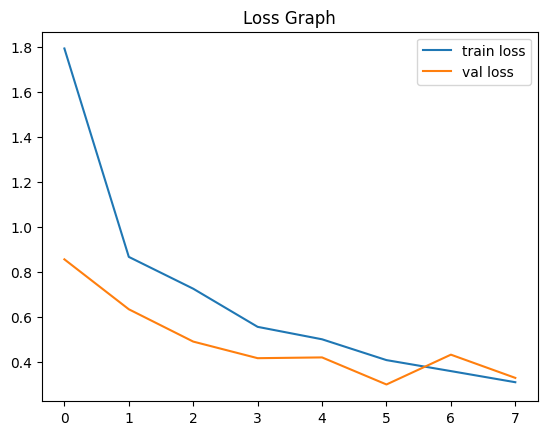

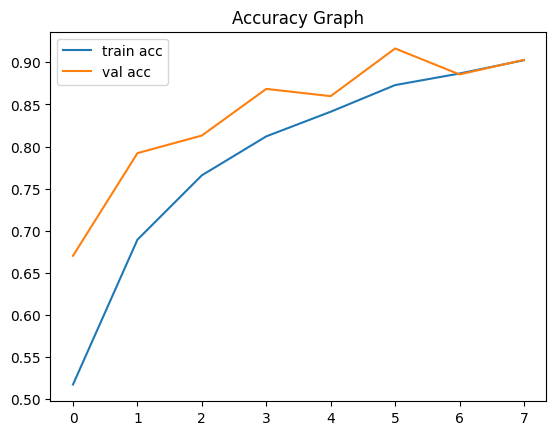

In [14]:
# Plot the loss
plt.title('Loss Graph')
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.title('Accuracy Graph')
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [21]:
# Preprocess Image before predicting
def preprocess(img_input):
  img = image.load_img(img_input, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
  img_array = img_array / 255.0  # Rescale if necessary
  return img_array

In [32]:
# Predict function
def predict(model, img_to_predict):
  img_array = preprocess(img_to_predict)
  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)

  plt.title(f"\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
  display_img = cv2.imread(img_to_predict)
  plt.imshow(display_img)
  return predicted_class, confidence

In [36]:
# Get Image using URL
!wget https://mediapool.bmwgroup.com/cache/P9/202205/P90462867/P90462867-rolls-royce-phantom-series-ii-2250px.jpg -O /content/image.png

--2024-05-30 08:09:34--  https://mediapool.bmwgroup.com/cache/P9/202205/P90462867/P90462867-rolls-royce-phantom-series-ii-2250px.jpg
Resolving mediapool.bmwgroup.com (mediapool.bmwgroup.com)... 160.46.226.184
Connecting to mediapool.bmwgroup.com (mediapool.bmwgroup.com)|160.46.226.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137144 (134K) [image/jpeg]
Saving to: ‘/content/image.png’

/content/image.png  100%[===================>] 133.93K   284KB/s    in 0.5s    

2024-05-30 08:09:36 (284 KB/s) - ‘/content/image.png’ saved [137144/137144]



1/1 [==============================] - 0s 207ms/step


('Rolls Royce', 100.0)

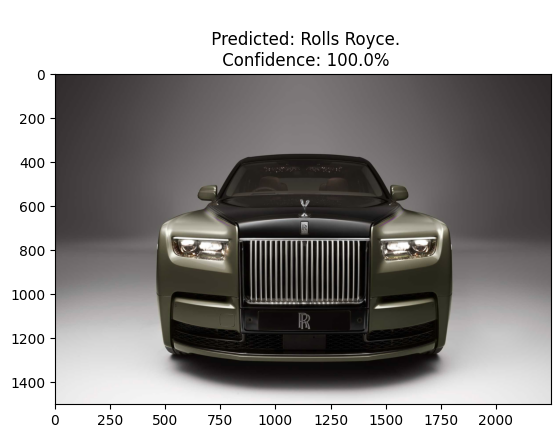

In [38]:
# Provide image for prediction
img_to_predict = '/content/image.png'
predict(model, img_to_predict)